In [1]:
#imports

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"# Assign which GPU to run on if using a multi-GPU device

import cupy as cp
import cupyx as cpx
from cupyx.scipy import special
import numpy as np
import numpy.matlib
import scipy as sp
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"#Unreal data is in .EXR format which may trigger firewalls. This line allows .EXR files to be read correctly
import cv2
from matplotlib.cm import ScalarMappable
import time
from tqdm import tqdm
import random

plt.rcParams['figure.dpi'] = 150#Only for display purposes in JupyterNotebook


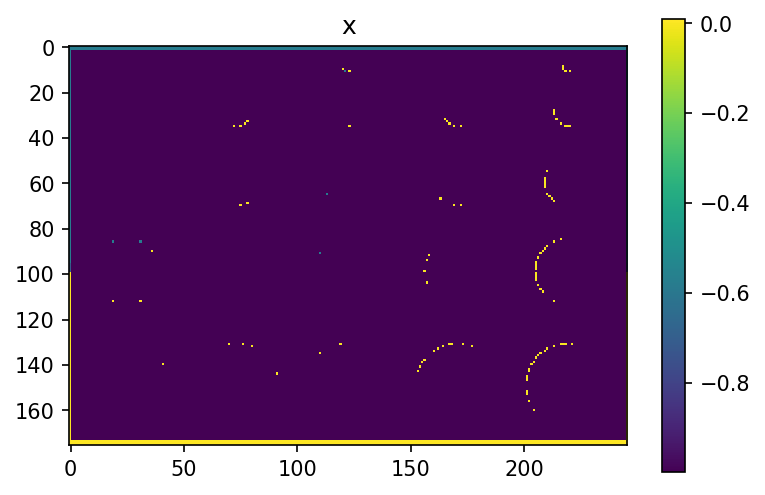

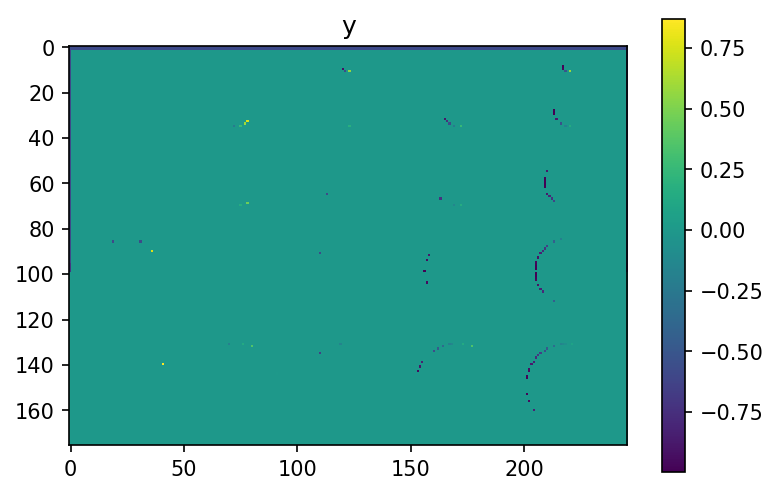

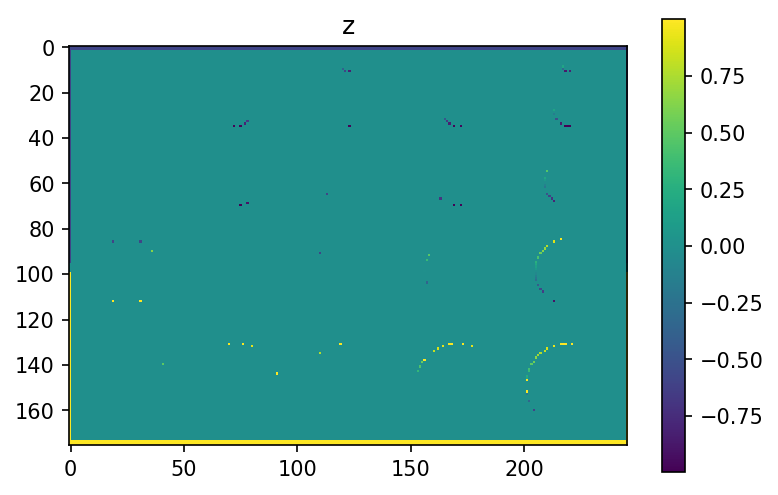

In [2]:
#Reads in the surface normal image from Unreal
normal = cv2.imread("Normal_3_0.EXR",cv2.IMREAD_UNCHANGED)#The UNCHANGED flag ensures the data is not normalised during read in

#print(normal.shape)

normal = cv2.cvtColor(normal[:,:,0:3],cv2.COLOR_BGR2RGB)#Converts the cv2 bgr index to rgb index matching Unreals x,y,z indexing scheme

# Vizulization of surface normal components
plt.imshow(normal[:,:,0],interpolation='none')
plt.colorbar()
plt.title("x")
plt.show()
plt.imshow(normal[:,:,1],interpolation='none')
plt.colorbar()
plt.title("y")
plt.show()
plt.imshow(normal[:,:,2],interpolation='none')
plt.colorbar()
plt.title("z")
plt.show()

(176, 246, 4)


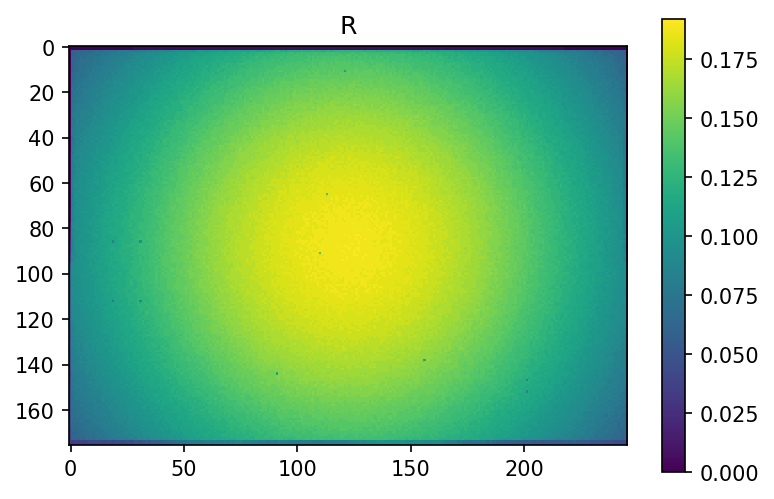

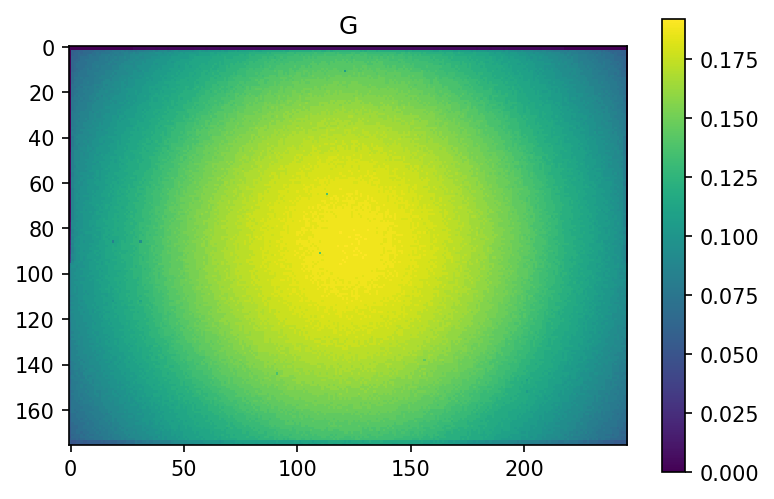

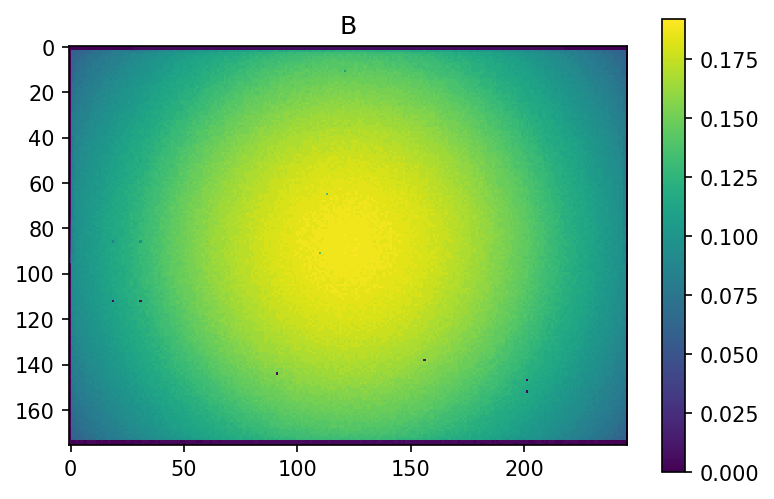

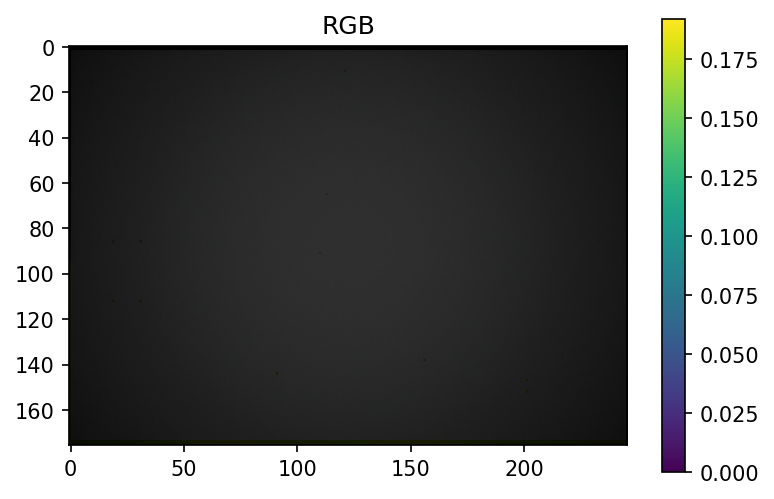

In [3]:
#Reads in base colour image from Unreal which is used for reflectivity calculation
base_c = cv2.imread("Base_Col_3_0.EXR",cv2.IMREAD_UNCHANGED)#The UNCHANGED flag ensures the data is not normalised during read in
print(base_c.shape)

base_c = cv2.cvtColor(base_c[:,:,0:3],cv2.COLOR_BGR2RGB)#Converts the cv2 bgr index to rgb index matching Unreals rgb indexing scheme

# Vizulization of base colour components
plt.imshow(base_c[:,:,0],interpolation='none')
plt.colorbar()
plt.title("R")
plt.show()
plt.imshow(base_c[:,:,1],interpolation='none')
plt.colorbar()
plt.title("G")
plt.show()
plt.imshow(base_c[:,:,2],interpolation='none')
plt.colorbar()
plt.title("B")
plt.show()

plt.imshow(base_c,interpolation='none')
plt.colorbar()
plt.title("RGB")
plt.show()

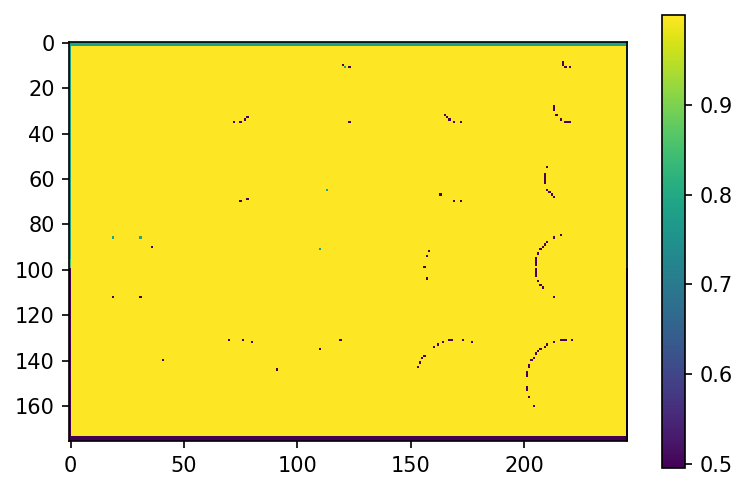

In [4]:
cam_vec = np.asarray([1,0,0])#camera vector (x,y,z) manual input

cam_vec_mag = np.sqrt(np.sum(cam_vec**2))#magnitude of camera forward vector

norm_mag = np.sqrt(np.sum(normal**2,axis=2))#normalized magnitude of camera forward vector

norm_prod = cam_vec_mag*norm_mag#normalized product

#plt.imshow(norm_prod,interpolation='none')
#plt.colorbar()
#plt.show()

dot_p1 = np.sum(cam_vec*normal,axis=2) # The first component of the dot product

#plt.imshow(dot_p1,interpolation='none')
#plt.colorbar()
#plt.show()

#The lambertian scattering angle defined with respect to the surface normal. Divison by 0 exceptions are handeled by the where flag.
lambertian_ang = 1-((np.divide(dot_p1, norm_prod, out=np.zeros_like(dot_p1), where=norm_prod!=0)+1)/2)

plt.imshow(lambertian_ang,interpolation='none')
plt.colorbar()
plt.show()


In [5]:
#Reads in red green blue depth image from Unreal
RGBD = cv2.imread("RGBD_3_0.EXR",cv2.IMREAD_UNCHANGED)#The UNCHANGED flag ensures the data is not normalised during read in

inten = cv2.cvtColor(RGBD[:,:,0:3],cv2.COLOR_BGR2GRAY)#Converts the first three channels of the image to greyscale
depth = RGBD[:,:,3]#Extracts the 4 channel in the image as the ground truth depth

#

#print("depth_min: ",np.amin(depth))
#print("depth_max: ",np.amax(depth))

c_speed = 2.99e8# The speed of light

#plt.imshow(depth,vmin = 1460,vmax = 1700,interpolation='none')
#plt.show()

depth = cv2.medianBlur(depth,3)#Median filters the depth to remove artifacts from Unreal rendering

depth = depth/100.0#Converts Unreal units which are centimeters to meters

peak_pos = (depth/c_speed)#Converts the depth to time

peak_pos = peak_pos - np.amin(peak_pos)#Converts the image to a relative depth



In [6]:
#Initial image size, the y axis has been cropped from 192 to 176 pixels and the x axis has been double to 256 then cropped to 246
img_x = 246
img_y = 176

c1 = np.arange(2,img_x,4)#The columns from 2 to 246 in steps of 4
c2 = c1+1 #The adjacent set of columns

c3 = np.vstack((c1,c2)).reshape((-1,),order='F') #This line arranges sets of pairs of columns to be used as indices

#print(c3)

peak_pos_2 = peak_pos[2:174,c3]#Reduces the rows to the final size and removes half of the columns from the image but does so in two column pairs. This is to match the 2:1 aspect ratio of the pixels on the sensor

peak_pos_2 = (peak_pos_2-np.amin(peak_pos_2))#Converts the image to a relative depth

peak_pos_2 = (peak_pos_2*2.0)+3.0e-9#Doubles the depth values so that they correspond to the total time of flight. Also offsets the minimum depth value so that the histograms do not start in bin 0



In [7]:
def calc_img(pix_y,pix_x,peak_po,sig):

    #This function adds to each pixels' depth a random value drawn from a normal distribution according to the Fisher information

    mu = cp.zeros((pix_y,pix_x))

    off_set = cp.random.normal(mu, sig, size = (pix_y,pix_x))

    spad_img = peak_po+off_set    

    return spad_img

In [8]:
def calc_liklyhood(num_frames,C_ref,bckg_refs,bins,exp_time,rep_rate,energy_per_pulse,peak_posi,pulse_width_fwhm,spad_q_efficiency,t_res,target_range,illum_radius,effictive_pix_size_x,effictive_pix_size_y,f_no,dark_count_rate,solar_background_per_meter):
    
    #This function calculates the number of photons per pulse.

    illum_area = cp.pi*(illum_radius)**2#The area illuminated by the laser

    C_atm = (10**(-1*(7e-4/10.0)))#The transmission coefficent of the atmosphere

    wavelength = 671e-9 #Wavelength of pulse laser

    c_speed = 2.99e8 #speed of light
    plank = 6.626e-34 #Planks constant

    sig_photon = ((wavelength*energy_per_pulse)/(plank*c_speed))*((spad_q_efficiency*C_ref*(C_atm**(2*target_range)))/(8*((f_no**2))))*((effictive_pix_size_x*effictive_pix_size_y)/(illum_area))#The average number of photons measured by the detector per laser pulse

    dark_counts = dark_count_rate #The dark count rate of the detector

    solar_background_off_of_target_photon = ((wavelength*solar_background_per_meter)/(plank*c_speed))*((spad_q_efficiency*bckg_refs*(C_atm**(target_range)))/(8*((f_no**2))))*((effictive_pix_size_x*effictive_pix_size_y)/(illum_area))#The average number of solar background photons measured by the detector per laser pulse

    return sig_photon,solar_background_off_of_target_photon

In [9]:
def calc_cont_fisher_info(peak_posi,jitter,num_pulses,bins,t_res,solar_background_off_of_target_photon,dark_count_rate,sig_photon,pulse_width_fwhm,num_frames):
    
    #This function calculates the fisher information

    r = peak_posi.shape[0] #Rows in the image
    c = peak_posi.shape[1] #Columns in the image

    t_vec_samples = 5000 # High resolution vector in time for calculations
    t_vec = cp.linspace(0,bins,t_vec_samples)*t_res #TCSPC window
    t_vec = cp.tile(t_vec,(r,c,1))#The TCSPC window tiled out to the image size
    #print("t_vec shape",t_vec.shape)

    sigma = pulse_width_fwhm/(2*cp.sqrt(2*cp.log(2)))#The width of the impulse reponse function
    sigma = cp.ones((r,c,t_vec_samples))*sigma#The width value expanded to an array
    

    sig_photon = cp.ones((r,c,t_vec_samples))*sig_photon# The average number of signal photons measured expanded to an array
    

    solar_background_off_of_target_photon = cp.ones((r,c,t_vec_samples))*solar_background_off_of_target_photon# The average number of solar background photons expanded to an array
   

    dark_count_rate = cp.ones((r,c,t_vec_samples))*dark_count_rate#The average number of dark counts expanded to an array
    

    peak_posi = cp.repeat(peak_posi[:,:,cp.newaxis],t_vec_samples,axis=2)#The true depth value repeated along axis 2 to allow for array operations
    

    numer = ((sig_photon)**2)*((t_vec-peak_posi)**2)*cp.exp(-((t_vec-peak_posi)/(sigma))**2)#The numerator of the fisher info equation

    alpha = (((solar_background_off_of_target_photon+dark_count_rate)*(t_res*bins))+sig_photon)#The alpha constant

    denom = ((sigma**6)*(2*cp.pi*alpha))*(solar_background_off_of_target_photon+dark_count_rate+((sig_photon/(sigma*cp.sqrt(2.0*cp.pi)))*(cp.exp(-0.5*((t_vec-peak_posi)/sigma)**2))))#The denominator of the fisher info equation


    fisher_vec = numer/denom#The fisher information integrand for each pixel

    fisher_info = np.trapz(cp.asnumpy(fisher_vec),cp.asnumpy(t_vec),axis=2)#The fisher information for each pixel

    return fisher_info,alpha[:,:,0]

In [10]:
def make_imgs(bins,peak_posi,jitter,C_ref,bckg_refs,num_frames,f_num,num_imgs,pix_x,pix_y):
    #This function creates images using the fisher information sampling approach
    

    fps = 1000#The cameras operational frame rate

    exp_time = 1/fps#The exposure time

    rep_rate = 2.25e6#The repition rate of the laser

    energy_per_pulse = 1.219e-9#The pulse energy of the laser

    pulse_width_fwhm = 0.6e-9#The pulse width of the laser

    t_res = 50e-12#The temproal resolution of the SPAD

    num_pulses = int(cp.round(exp_time*rep_rate))#The number of pulses in a frame
    
    spad_q_base_efficiency = 0.18#The effective quantum efficiency of the SPAD

    spad_q_efficiency = spad_q_base_efficiency
        
    target_range = 14.73#The range to the target

    fibre_core = 550e-6#The size of the fibre core used for illumination
    illum_lens = 8e-3#The focal length of the illuminating lens

    illum_radius = ((target_range/illum_lens)*fibre_core)/2.0#The radius of the illuminated area

    effictive_pix_size_x = 9.2e-6#The effective size of the pixels including fill factor
    effictive_pix_size_y = 9.2e-6#The effective size of the pixels including fill factor

    f_no = f_num#The f number of the lens

    dark_count_rate = 126# specific to our sensor
    solar_background_per_meter = 0.0# Set to zero since the experiment was conducted indoors

    sig_photon,solar_background_off_of_target_photon = calc_liklyhood(num_frames,C_ref,bckg_refs,bins,exp_time,rep_rate,energy_per_pulse,peak_posi,pulse_width_fwhm,spad_q_efficiency,t_res,target_range,illum_radius,effictive_pix_size_x,effictive_pix_size_y,f_no,dark_count_rate,solar_background_per_meter)#The average number of signal and background photons measured by the sensor per pulse

    cont_fisher_info,alpha = calc_cont_fisher_info(peak_posi,jitter,num_pulses,bins,t_res,solar_background_off_of_target_photon,dark_count_rate,sig_photon,pulse_width_fwhm,num_frames)#The Fisher information for each pixel

    photon_per_frame = 1-((1-alpha)**num_pulses) #The average number of photons per frame
    spc_ave = num_frames*(photon_per_frame)#The average number of photons in a histogram
    spc_std = cp.sqrt(num_frames*(photon_per_frame)*(1-photon_per_frame))#The standard deviation in the number of measured photons

    spc = cp.round(cp.random.normal(spc_ave, spc_std))#The number of photons measured 

    sig = (((1/(cp.sqrt(spc*cp.asarray(cont_fisher_info))))))/cp.asarray(t_res)#The Cramer-Rao bound

    peak_posi = cp.asarray(peak_posi/t_res)#The peak positions converted to bin index

    spad_com_img = cp.zeros((pix_y,pix_x,num_imgs))#Pre-allocating the number of images

    for i in tqdm(range(0,num_imgs)):
        spad_com_img[:,:,i] = calc_img(pix_y,pix_x,peak_posi,sig)#calculating each image

    
    return cp.asnumpy(spad_com_img)

100%|██████████| 1/1 [00:00<00:00, 2478.90it/s]


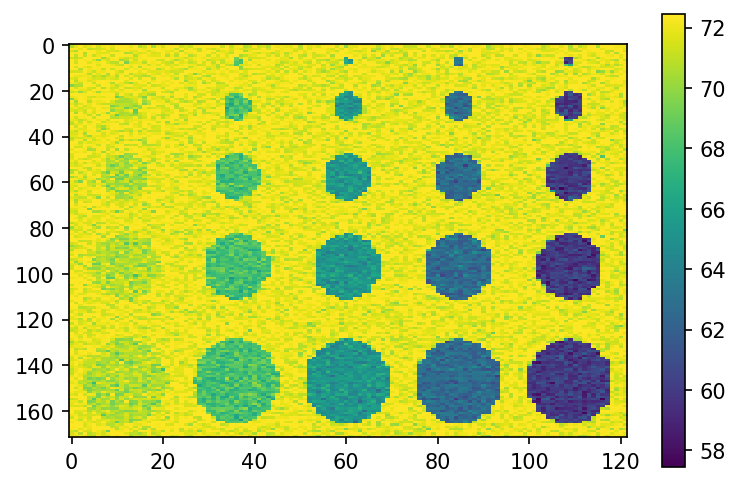

In [14]:
bins = 100#The number of bins. Only a subset is used to improve computation speed

num_frames = 100#The number of frames used in the "histogram"

num_imgs = 1 # The number of images to generate

pix_x = 122#The final number of pixels in x
pix_y = 172#The final number of pixels in y

total_pix = pix_x*pix_y

#histo_frames = np.zeros((pix_y,pix_x,target_frame_num))#Pre allocating click array

jitter = 220e-12#inter-pulse jitter

f_num = 2.0#lens f_num

pixel_jit_map_max = 1.0e-9# maximum inter-frame inter-pixel column wise jitter
pixel_jit_map_min = pixel_jit_map_max/4.0 # minimum inter-frame inter-pixel column wise jitter

pixel_jit_sig = np.linspace(pixel_jit_map_min/6.0,pixel_jit_map_max/6.0,pix_x)#An  inter-frame inter-pixel jitter vector varying linearly across the SPAD

pixel_jit_map = np.zeros((pix_y,pix_x))#Pre allocating the inter-frame inter-pixel jitter array

final_img = make_imgs(bins,cp.asarray(peak_pos_2+pixel_jit_map),jitter,0.08956,0.08956,num_frames,f_num,num_imgs,pix_x,pix_y)#Simulating the image


plt.imshow(final_img[:,:,0],vmin = np.amin(final_img[:,:,0]),vmax = np.amin(final_img[:,:,0])+15,interpolation='none', aspect='0.5')#Display the image
plt.colorbar()
plt.show()  


